## Import the required libraries and the utility modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 5.3 MB/s 


In [4]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

#Custom libraries
#Data formating library
from dataloadinglibrary import loadCSV

from datainspection1 import getStatisticsOfData

from dataformatinglibrary import createExcelFromArray

from Inputs import getLabelName
from Inputs import getPathToTrainingAndTestingDataSets
from Inputs import modelPerformanceReport
from Inputs import defineArrayForPreProcessing

from utilss3 import performPreprocessing

### Load the training dataset and check the statistics

In [5]:
#Define file names and call loadCSV to load the CSV files
trainingFileNameWithAbsolutePath, testingFileNameWithAbsolutePath = getPathToTrainingAndTestingDataSets()
trainingDataSet = loadCSV(trainingFileNameWithAbsolutePath)
difficultyLevel = trainingDataSet.pop('difficulty_level')
labelName = getLabelName()
label = trainingDataSet[labelName]

#Look at the statistics of the dataSet
getStatisticsOfData(trainingDataSet)
print("\n***** Here is how to training dataset looks like before performing any pre-processing *****")
trainingDataSet.head()

***** Start checking the statistics of the dataSet *****

***** Shape (number of rows and columns) in the dataset:  (25191, 42)
***** Total number of features in the dataset:  41
***** Number of categorical features in the dataset:  3
***** Number of numerical features in the dataset:  38

***** Names of categorical features in dataset *****

| Categorical features in dataset   |
|-----------------------------------|
| Flag                              |
| Protocol_type                     |
| Service                           |


***** Names of numerical features in dataset *****

| Numerical features in the dataset   |
|-------------------------------------|
| Duration                            |
| Src_bytes                           |
| Dst_bytes                           |
| Land                                |
| Wrong_fragment                      |
| Urgent                              |
| Hot                                 |
| Num_failed_logins                   |
| Logged_in

,Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Land,Wrong_fragment,Urgent,Hot,...,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_srv_diff_host_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,Dst_host_srv_rerror_rate,attack_type
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


### Load the testing dataset and check the statistics

In [6]:
#Define file names and call loadCSV to load the CSV files
testingDataSet = loadCSV(testingFileNameWithAbsolutePath)
difficultyLevel = testingDataSet.pop('difficulty_level')

#Look at the statistics of the dataSet
getStatisticsOfData(testingDataSet)
print("\n***** Here is how to testing dataset looks like before performing any pre-processing *****")
testingDataSet.head()

***** Start checking the statistics of the dataSet *****

***** Shape (number of rows and columns) in the dataset:  (11850, 42)
***** Total number of features in the dataset:  41
***** Number of categorical features in the dataset:  3
***** Number of numerical features in the dataset:  38

***** Names of categorical features in dataset *****

| Categorical features in dataset   |
|-----------------------------------|
| Flag                              |
| Protocol_type                     |
| Service                           |


***** Names of numerical features in dataset *****

| Numerical features in the dataset   |
|-------------------------------------|
| Duration                            |
| Src_bytes                           |
| Dst_bytes                           |
| Land                                |
| Wrong_fragment                      |
| Urgent                              |
| Hot                                 |
| Num_failed_logins                   |
| Logged_in

,Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Land,Wrong_fragment,Urgent,Hot,...,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_srv_diff_host_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,Dst_host_srv_rerror_rate,attack_type
0,13,tcp,telnet,SF,118,2425,0,0,0,0,...,10,0.38,0.12,0.04,0.0,0.00,0.00,0.12,0.3,guess_passwd
1,0,udp,private,SF,44,0,0,0,0,0,...,254,1.00,0.01,0.01,0.0,0.00,0.00,0.00,0.0,snmpguess
2,0,tcp,telnet,S3,0,44,0,0,0,0,...,79,0.31,0.61,0.00,0.0,0.21,0.68,0.60,0.0,processtable
3,0,udp,private,SF,53,55,0,0,0,0,...,255,1.00,0.00,0.87,0.0,0.00,0.00,0.00,0.0,normal
4,0,tcp,private,SH,0,0,0,0,0,0,...,1,0.06,1.00,1.00,0.0,1.00,1.00,0.00,0.0,nmap


### Perform pre-processing

In [7]:
arrayOfModels = defineArrayForPreProcessing()
completeEncodedAndScaledDataset = performPreprocessing(trainingDataSet, testingDataSet, arrayOfModels)
completeEncodedAndScaledDataset.head()

[['ExtraTreesClassifier', 'OneHotEncoder', 'Standardization']]
***************************************************************************************************************************
********************************************* Building Model- 0  As Below *************************************************
	 -- Feature Selection: 	  ExtraTreesClassifier  
	 -- Feature Encoding: 	  OneHotEncoder  
	 -- Feature Scaling: 	  Standardization 

completeDataSet.shape:  (37041, 43)
completeDataSet.head:     Duration Protocol_type  Service Flag  Src_bytes  Dst_bytes  Land  \
0         0           udp    other   SF        146          0     0   
1         0           tcp  private   S0          0          0     0   
2         0           tcp     http   SF        232       8153     0   
3         0           tcp     http   SF        199        420     0   
4         0           tcp  private  REJ          0          0     0   

   Wrong_fragment  Urgent  Hot  ...  Dst_host_same_srv_rate  \
0    

,Protocol_type,Service,Flag,Src_bytes,Logged_in,Count,Serror_rate,Srv_serror_rate,Same_srv_rate,Diff_srv_rate,Dst_host_count,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,difficulty_level,attack_type
0,2.038571,0.629977,0.735369,-0.011190,-0.732914,-0.581217,-0.556584,-0.552030,-1.421427,0.233303,0.656445,-1.050270,-1.193023,2.187298,2.137976,-0.561390,-0.549814,-0.487765,-0.853801,normal
1,-0.154786,0.938904,-0.660992,-0.011262,-0.732914,0.275339,1.851192,1.851769,-1.491319,-0.092358,0.656445,-0.821669,-0.966271,-0.237144,-0.498320,1.904034,1.899674,-0.487765,0.228139,neptune
2,-0.154786,-0.543948,0.735369,-0.011147,1.364417,-0.643512,-0.075029,-0.071270,0.721924,-0.377312,-1.709884,1.272317,1.074493,-0.457548,-0.408446,-0.487427,-0.525319,-0.487765,0.769108,normal
3,-0.154786,-0.543948,0.735369,-0.011163,1.364417,-0.448840,-0.556584,-0.552030,0.721924,-0.377312,0.656445,1.272317,1.074493,-0.457548,-0.498320,-0.561390,-0.549814,-0.487765,0.769108,normal
4,-0.154786,0.938904,-2.057353,-0.011262,-0.732914,0.259766,-0.556584,-0.552030,-1.235049,-0.133066,0.656445,-0.885678,-1.034297,-0.148983,-0.498320,-0.561390,-0.549814,2.476323,0.769108,neptune


### After preprocessing, check the shape of the features and label

In [8]:
x = completeEncodedAndScaledDataset.drop('attack_type',axis=1)
y = completeEncodedAndScaledDataset['attack_type']
print(x.shape, y.shape)
print(len(x.columns))
print(x.columns)

(37041, 19) (37041,)
19
Index(['Protocol_type', 'Service', 'Flag', 'Src_bytes', 'Logged_in', 'Count',
       'Serror_rate', 'Srv_serror_rate', 'Same_srv_rate', 'Diff_srv_rate',
       'Dst_host_count', 'Dst_host_srv_count', 'Dst_host_same_srv_rate',
       'Dst_host_diff_srv_rate', 'Dst_host_same_src_port_rate',
       'Dst_host_serror_rate', 'Dst_host_srv_serror_rate',
       'Dst_host_rerror_rate', 'difficulty_level'],
      dtype='object')


In [9]:
np.unique(y)
y.value_counts()

normal             15600
neptune             9861
satan               1418
guess_passwd        1241
smurf               1156
mscan                996
warezmaster          951
ipsweep              851
portsweep            743
apache2              737
processtable         685
back                 555
nmap                 374
snmpguess            331
saint                309
mailbomb             293
teardrop             200
warezclient          181
snmpgetattack        178
httptunnel           133
pod                   79
buffer_overflow       26
multihop              20
named                 17
rootkit               17
ps                    15
sendmail              14
xterm                 13
xlock                  9
land                   8
imap                   6
phf                    4
xsnoop                 4
ftp_write              4
loadmodule             3
worm                   2
udpstorm               2
perl                   2
sqlattack              2
spy                    1


### Split the normal data and fraud data

In [10]:
x_normal , x_fraud = x[y=='normal'], x[y!='normal']
print(x_normal.shape, x_fraud.shape)

(15600, 19) (21441, 19)


### Start creating the autoencoder 

In [11]:
def auto_encoder(x, layers):
  rlayers=layers[::-1]
  input_layer = Input(shape=(x.shape[1],))
  encoded=Dense(layers[0], activation='relu' , activity_regularizer=regularizers.l2(10e-5))(input_layer)
  for l in layers[1:]:
    encoded= Dense(l, activation='relu')(encoded)
  decoded=Dense(rlayers[0], activation='relu' )(encoded)
  for l in rlayers[1:]:
    decoded=Dense(l, activation='relu')(decoded)
  output_layer = Dense(x.shape[1], activation='relu')(decoded)

  
  return input_layer,output_layer

### Define the autoencoder

In [12]:
layers=[400,200,100,25,15]
in_layer, out_layer = auto_encoder(x_normal,layers)
autoencoder = Model(in_layer,out_layer)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense (Dense)               (None, 400)               8000      
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 25)                2525      
                                                                 
 dense_4 (Dense)             (None, 15)                390       
                                                                 
 dense_5 (Dense)             (None, 15)                240   

### Compile the autoencoder

In [13]:
autoencoder.compile(optimizer='rmsprop', loss='mse')

### Fit the autoencoder

In [14]:
auto_hist = autoencoder.fit(x_normal, x_normal, batch_size=16, epochs=80, shuffle=True, validation_split=0.2)

Epoch 1/80
780/780 [==============================] - 10s 7ms/step - loss: 0.3648 - val_loss: 0.5420
Epoch 2/80
780/780 [==============================] - 9s 11ms/step - loss: 0.3375 - val_loss: 0.5405
Epoch 3/80
780/780 [==============================] - 5s 7ms/step - loss: 0.3355 - val_loss: 0.5318
Epoch 4/80
780/780 [==============================] - 5s 7ms/step - loss: 0.3345 - val_loss: 0.5267
Epoch 5/80
780/780 [==============================] - 5s 7ms/step - loss: 0.3330 - val_loss: 0.5257
Epoch 6/80
780/780 [==============================] - 5s 7ms/step - loss: 0.3290 - val_loss: 0.5145
Epoch 7/80
780/780 [==============================] - 5s 6ms/step - loss: 0.3144 - val_loss: 0.4919
Epoch 8/80
780/780 [==============================] - 5s 7ms/step - loss: 0.3117 - val_loss: 0.4927
Epoch 9/80
780/780 [==============================] - 5s 7ms/step - loss: 0.3113 - val_loss: 0.4936
Epoch 10/80
780/780 [==============================] - 5s 6ms/step - loss: 0.3109 - val_loss: 0.49

### Plot the autoencoder los curves for all the epochs, as it is being fit

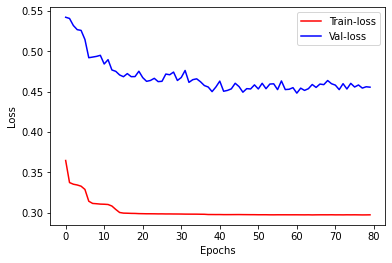

In [15]:
plt.plot(range(80), auto_hist.history['loss'],'r', label='Train-loss')
plt.plot(range(80), auto_hist.history['val_loss'],'b', label='Val-loss')
#plt.title('Dataset2: Autoencoder: Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Creating the hidden layers in the neural network using the layers from the autoencoder

In [16]:
hidden =Sequential()
hidden.add(autoencoder.layers[0])
hidden.add(autoencoder.layers[1])
hidden.add(autoencoder.layers[2])
hidden.add(autoencoder.layers[3])
hidden.add(autoencoder.layers[4])
hidden.add(autoencoder.layers[5])
hidden.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               8000      
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 25)                2525      
                                                                 
 dense_4 (Dense)             (None, 15)                390       
                                                                 
Total params: 111,215
Trainable params: 111,215
Non-trainable params: 0
_________________________________________________________________


In [17]:
normal_hidden= hidden.predict(x_normal)
fraud_hidden = hidden.predict(x_fraud)
print(normal_hidden.shape, fraud_hidden.shape)

(15600, 15) (21441, 15)


In [18]:
rep_x = np.append(normal_hidden, fraud_hidden, axis=0)
y_normal = np.zeros(normal_hidden.shape[0])
y_fraud = np.ones(fraud_hidden.shape[0])
rep_y = np.append(y_normal,y_fraud)

x_lat=rep_x
y_lat=rep_y
print(x_lat.shape, y_lat.shape)

(37041, 15) (37041,)


## Build a neural Network model

In [23]:
layers=[900,700,500,400,300,200,100,50,15]
trainx, testx, trainy, testy = train_test_split(x_lat,y_lat, test_size=0.20, random_state=42)

In [24]:
model = Sequential()
model.add(Dense(layers[0],activation='relu', input_shape=(trainx.shape[1],)))
for l in layers[1:]:
  model.add(Dense(l, activation='relu' ))
  model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 900)               14400     
                                                                 
 dense_22 (Dense)            (None, 700)               630700    
                                                                 
 dropout_8 (Dropout)         (None, 700)               0         
                                                                 
 dense_23 (Dense)            (None, 500)               350500    
                                                                 
 dropout_9 (Dropout)         (None, 500)               0         
                                                                 
 dense_24 (Dense)            (None, 400)               200400    
                                                                 
 dropout_10 (Dropout)        (None, 400)              

In [25]:
model3 = model.fit(trainx, trainy, batch_size=16, epochs=120, shuffle=True, validation_data=(testx,testy), verbose=True)

Epoch 1/120
1852/1852 [==============================] - 16s 7ms/step - loss: 0.2340 - accuracy: 0.9155 - val_loss: 0.1196 - val_accuracy: 0.9609
Epoch 2/120
1852/1852 [==============================] - 16s 9ms/step - loss: 0.1404 - accuracy: 0.9528 - val_loss: 0.1170 - val_accuracy: 0.9564
Epoch 3/120
1852/1852 [==============================] - 15s 8ms/step - loss: 0.1200 - accuracy: 0.9626 - val_loss: 0.1337 - val_accuracy: 0.9463
Epoch 4/120
1852/1852 [==============================] - 13s 7ms/step - loss: 0.1173 - accuracy: 0.9645 - val_loss: 0.0981 - val_accuracy: 0.9707
Epoch 5/120
1852/1852 [==============================] - 14s 8ms/step - loss: 0.1107 - accuracy: 0.9646 - val_loss: 0.1025 - val_accuracy: 0.9576
Epoch 6/120
1852/1852 [==============================] - 14s 8ms/step - loss: 0.1016 - accuracy: 0.9673 - val_loss: 0.0928 - val_accuracy: 0.9683
Epoch 7/120
1852/1852 [==============================] - 13s 7ms/step - loss: 0.0886 - accuracy: 0.9698 - val_loss: 0.1073 -

In [26]:
print('MAX Accuracy during training: ',max(model3.history['accuracy'])*100)
print('MAX Accuracy during validation: ',max(model3.history['val_accuracy'])*100)

MAX Accuracy during training:  98.4577476978302
MAX Accuracy during validation:  98.5693097114563


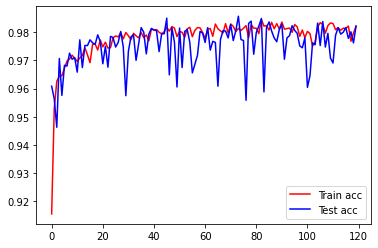

In [27]:
plt.plot(range(120), model3.history['accuracy'], 'r', label='Train acc')
plt.plot(range(120), model3.history['val_accuracy'], 'b', label='Test acc')
plt.legend()

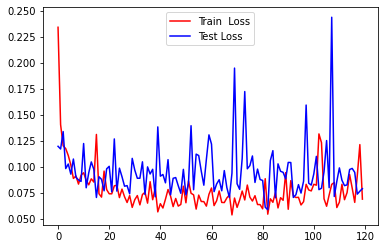

In [28]:
plt.plot(range(120), model3.history['loss'], 'r', label='Train  Loss')
plt.plot(range(120), model3.history['val_loss'], 'b', label='Test Loss')
plt.legend()

In [44]:
model.save('/content/drive/MyDrive/Final_Year_Project/NIDS_Autoencoder.h5')

In [85]:
predictions = model.predict(testx)
y_pred = [np.round(probas) for probas in predictions]
y_test = testy

In [92]:
predictions

array([[0.0000000e+00],
       [9.6033984e-01],
       [9.6181786e-01],
       ...,
       [0.0000000e+00],
       [2.1338650e-37],
       [9.9614090e-01]], dtype=float32)

In [94]:
y_pred = np.round(predictions)

In [97]:
y_pred = y_pred.reshape(-1)

In [99]:
y_pred

array([0., 1., 1., ..., 0., 0., 1.], dtype=float32)

In [100]:
y_test

array([0., 1., 1., ..., 0., 0., 1.])

In [101]:
from sklearn import metrics as m

print("Precision_weighted:", m.precision_score(y_test, y_pred, average="weighted")*100)
print("Recall_weighted:", m.recall_score(y_test, y_pred, average="weighted")*100)
print("F1_weighted:", m.f1_score(y_test, y_pred, average="weighted")*100)

Precision_weighted: 98.248521741102
Recall_weighted: 98.21838304764475
F1_weighted: 98.21424961526492


In [102]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


Number of misclassified attacks:  132
Percentage of misclassified attacks:  1.7816169523552436
-------------------------------------------------- Confusion Matrix --------------------------------------------------


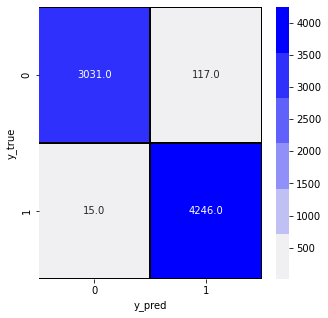

In [112]:
cm=confusion_matrix(y_test,y_pred)
print("Number of misclassified attacks: ", (len(y_test)-np.trace(cm)))
print("Percentage of misclassified attacks: ", (len(y_test)-np.trace(cm))*100/len(y_test))
print("-"*50, "Confusion Matrix", "-"*50)
f,ax=plt.subplots(figsize=(5,5))
cmap = sns.light_palette("blue")
sns.heatmap(cm,annot=True,cmap = cmap,linewidth=0.5,linecolor="black",fmt=".1f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### ++++++++++++++++++++++++++++++++++++++++END++++++++++++++++++++++++++++++++++++++++++++